# Step 1: Install Required Libraries

In [1]:
# Install any additional packages if needed
!pip install pandas scikit-learn matplotlib seaborn


# Step 2:Import Required Libraries

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Step 3: Load and Explore the Dataset

In [3]:


# Load the dataset (adjust the path to where you've uploaded the file)
file_path = '/content/Dataset .csv'  # Update this path
df = pd.read_csv(file_path)

# Display basic info about the dataset
print(df.info())
print(df.head())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   Country Code          9551 non-null   int64  
 3   City                  9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Locality Verbose      9551 non-null   object 
 7   Longitude             9551 non-null   float64
 8   Latitude              9551 non-null   float64
 9   Cuisines              9542 non-null   object 
 10  Average Cost for two  9551 non-null   int64  
 11  Currency              9551 non-null   object 
 12  Has Table booking     9551 non-null   object 
 13  Has Online delivery   9551 non-null   object 
 14  Is delivering now     9551 non-null   object 
 15  Switch to order menu 

# Step 4: Data Preprocessing

In [4]:
# Handle missing values in the 'Cuisines' column
df['Cuisines'] = df['Cuisines'].fillna('Unknown')

# For this task, we'll focus on cuisine classification using restaurant name and cuisine description
# Let's extract the primary cuisine (first one listed)
df['Primary_Cuisine'] = df['Cuisines'].apply(lambda x: x.split(',')[0].strip())

# Count the frequency of each primary cuisine
cuisine_counts = df['Primary_Cuisine'].value_counts()
print(cuisine_counts)

# Let's focus on the top N cuisines to simplify the classification
top_n = 10  # You can adjust this number
top_cuisines = cuisine_counts.index[:top_n]
df_filtered = df[df['Primary_Cuisine'].isin(top_cuisines)]

# Encode the target variable (cuisine)
label_encoder = LabelEncoder()
df_filtered['Cuisine_Label'] = label_encoder.fit_transform(df_filtered['Primary_Cuisine'])

# Prepare features - we'll use restaurant name and other text features
features = df_filtered[['Restaurant Name', 'Cuisines', 'City', 'Locality Verbose']]
target = df_filtered['Cuisine_Label']

# Combine text features into a single column
features['Combined_Text'] = features['Restaurant Name'] + ' ' + features['Cuisines'] + ' ' + features['City'] + ' ' + features['Locality Verbose']

Primary_Cuisine
North Indian     2992
Chinese           855
Fast Food         672
Bakery            621
Cafe              617
                 ... 
Indonesian          1
Sri Lankan          1
Argentine           1
Patisserie          1
Turkish Pizza       1
Name: count, Length: 120, dtype: int64


<ipython-input-4-9a080dd7b576>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Cuisine_Label'] = label_encoder.fit_transform(df_filtered['Primary_Cuisine'])
<ipython-input-4-9a080dd7b576>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Combined_Text'] = features['Restaurant Name'] + ' ' + features['Cuisines'] + ' ' + features['City'] + ' ' + features['Locality Verbose']


# Step 5: Split Data into Training and Testing Sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    features['Combined_Text'],
    target,
    test_size=0.2,
    random_state=42,
    stratify=target
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 5611
Testing set size: 1403


# Step 6: Feature Engineering with TF-IDF

In [6]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,  # Limit number of features to prevent overfitting
    stop_words='english',
    ngram_range=(1, 2)  # Consider both single words and word pairs
)

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf.transform(X_test)

# Step 7: Train Classification Models

## Option 1: Logistic Regression

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Performance:
              precision    recall  f1-score   support

    American       0.95      0.93      0.94        56
      Bakery       0.97      0.98      0.98       124
        Cafe       0.92      0.92      0.92       123
     Chinese       0.96      0.88      0.92       171
 Continental       0.90      0.60      0.72        47
   Fast Food       0.91      0.93      0.92       135
      Mithai       0.96      0.92      0.94        49
North Indian       0.95      0.99      0.97       599
South Indian       0.92      0.92      0.92        52
 Street Food       0.96      0.94      0.95        47

    accuracy                           0.94      1403
   macro avg       0.94      0.90      0.92      1403
weighted avg       0.94      0.94      0.94      1403

Accuracy: 0.9422665716322167


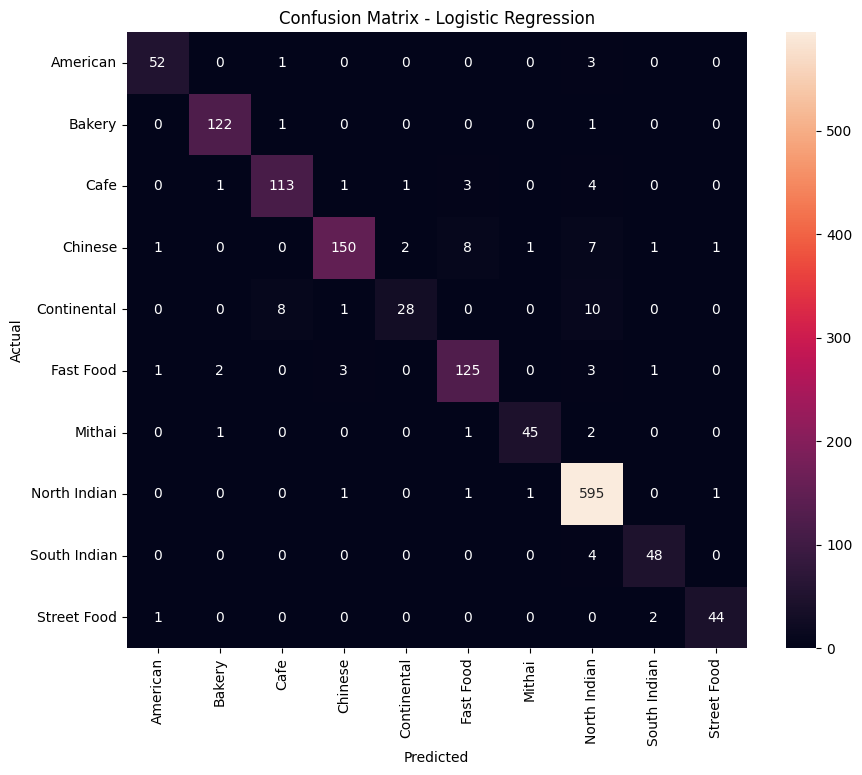

In [7]:
# Logistic Regression model
logreg = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42
)

logreg.fit(X_train_tfidf, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_test_tfidf)

# Evaluation
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logreg, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_logreg),
            annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Option 2: Random Forest

Random Forest Performance:
              precision    recall  f1-score   support

    American       0.95      0.95      0.95        56
      Bakery       0.97      0.98      0.98       124
        Cafe       0.93      0.85      0.89       123
     Chinese       0.94      0.90      0.92       171
 Continental       0.88      0.62      0.72        47
   Fast Food       0.94      0.90      0.92       135
      Mithai       0.93      0.88      0.91        49
North Indian       0.93      1.00      0.96       599
South Indian       0.94      0.88      0.91        52
 Street Food       1.00      0.91      0.96        47

    accuracy                           0.94      1403
   macro avg       0.94      0.89      0.91      1403
weighted avg       0.94      0.94      0.93      1403

Accuracy: 0.9358517462580185


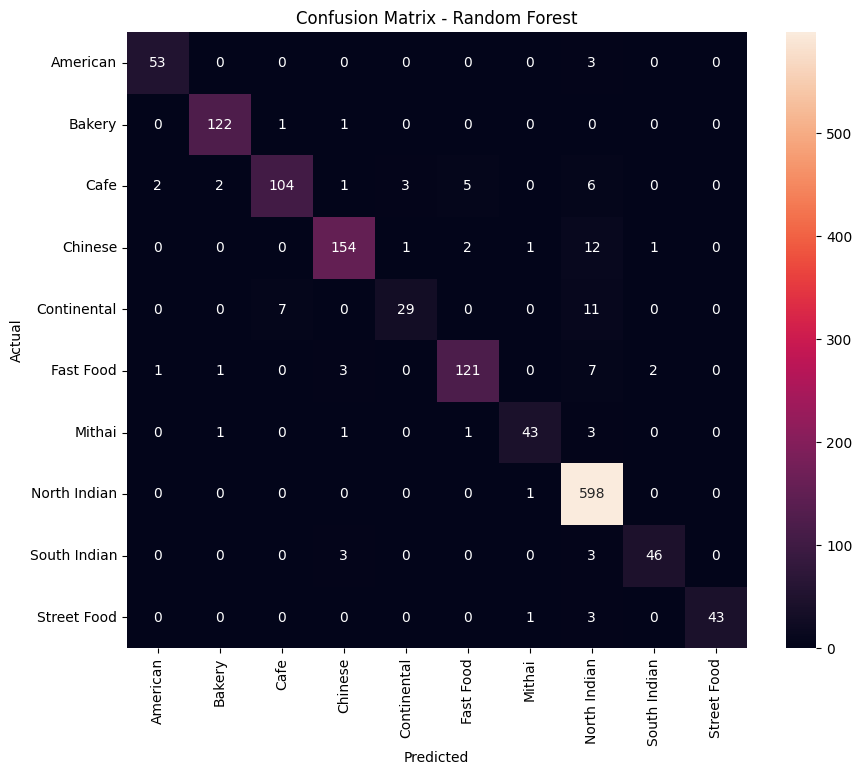

In [8]:
# Random Forest model
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Helps with imbalanced classes
)

rf.fit(X_train_tfidf, y_train)

# Predictions
y_pred_rf = rf.predict(X_test_tfidf)

# Evaluation
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
            annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 8: Model Analysis and Interpretation

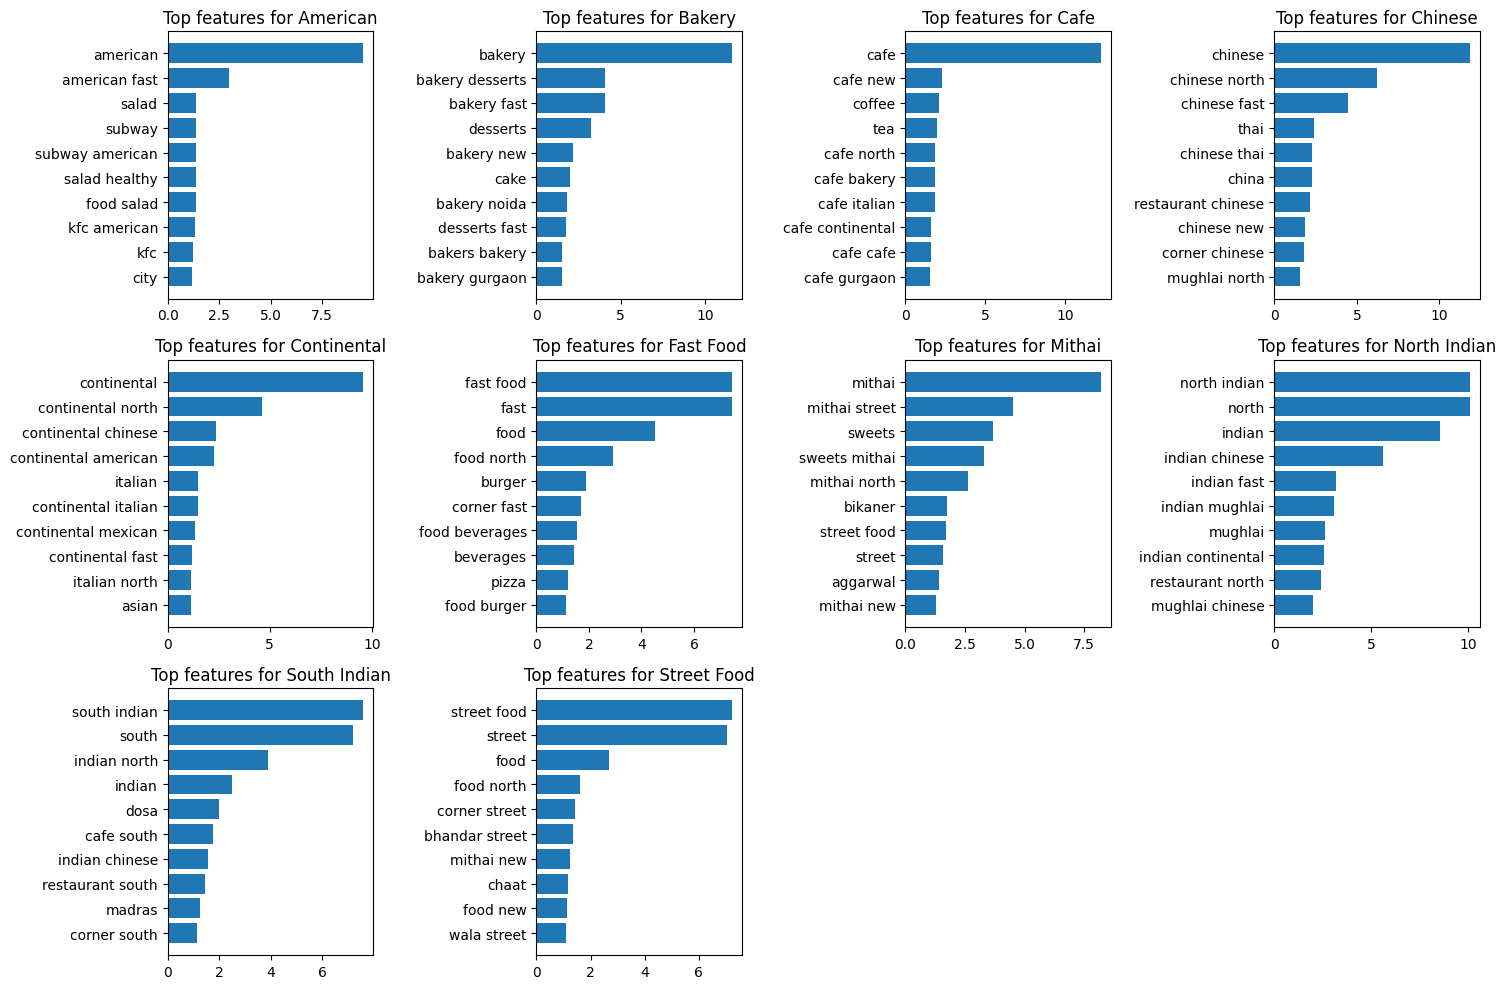

Model Comparison:
Logistic Regression Accuracy: 0.9422665716322167
Random Forest Accuracy: 0.9358517462580185


In [9]:
# Feature importance for Logistic Regression
feature_names = tfidf.get_feature_names_out()
coefs = logreg.coef_

# Plot top features for each cuisine
plt.figure(figsize=(15, 10))
for i, cuisine in enumerate(label_encoder.classes_):
    top_features = np.argsort(coefs[i])[-10:]  # Top 10 features
    plt.subplot(3, 4, i+1)
    plt.barh(range(10), coefs[i][top_features])
    plt.yticks(range(10), [feature_names[j] for j in top_features])
    plt.title(f"Top features for {cuisine}")
plt.tight_layout()
plt.show()

# Compare model performances
print("Model Comparison:")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_logreg)}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")

# Step 9: Handling Class Imbalance (Optional)

In [10]:
# Option 1: Adjust class weights in the models
# Already done in Random Forest with class_weight='balanced'
# For Logistic Regression:
logreg_balanced = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42,
    class_weight='balanced'
)
logreg_balanced.fit(X_train_tfidf, y_train)
y_pred_logreg_balanced = logreg_balanced.predict(X_test_tfidf)
print("Balanced Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logreg_balanced, target_names=label_encoder.classes_))

# Option 2: Use SMOTE for oversampling minority classes
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Train a model on the balanced data
logreg_smote = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)
logreg_smote.fit(X_train_smote, y_train_smote)
y_pred_logreg_smote = logreg_smote.predict(X_test_tfidf)
print("SMOTE + Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logreg_smote, target_names=label_encoder.classes_))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Balanced Logistic Regression Performance:
              precision    recall  f1-score   support

    American       0.89      0.98      0.93        56
      Bakery       0.98      0.98      0.98       124
        Cafe       0.94      0.91      0.93       123
     Chinese       0.97      0.85      0.91       171
 Continental       0.57      0.91      0.70        47
   Fast Food       0.88      0.91      0.90       135
      Mithai       0.91      0.98      0.94        49
North Indian       0.99      0.93      0.96       599
South Indian       0.90      1.00      0.95        52
 Street Food       0.77      0.98      0.86        47

    accuracy                           0.93      1403
   macro avg       0.88      0.94      0.90      1403
weighted avg       0.94      0.93      0.93      1403



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SMOTE + Logistic Regression Performance:
              precision    recall  f1-score   support

    American       0.90      0.98      0.94        56
      Bakery       0.98      0.98      0.98       124
        Cafe       0.94      0.90      0.92       123
     Chinese       0.97      0.89      0.93       171
 Continental       0.73      0.91      0.81        47
   Fast Food       0.91      0.92      0.91       135
      Mithai       0.96      0.98      0.97        49
North Indian       0.99      0.97      0.98       599
South Indian       0.93      0.98      0.95        52
 Street Food       0.88      0.98      0.93        47

    accuracy                           0.95      1403
   macro avg       0.92      0.95      0.93      1403
weighted avg       0.95      0.95      0.95      1403



## Example of how to use the trained model to classify a new restaurant

### This will:
Take a new restaurant description as input
Transform it using the same TF-IDF vectorizer we trained
Predict the cuisine using the logistic regression model
Convert the numerical label back to the actual cuisine name
Print the predicted cuisine



In [11]:
# Example of how to use the trained model to classify a new restaurant
new_restaurant_data = ["Sushi Palace Japanese Restaurant in Tokyo serving fresh sushi and sashimi"]
new_data_tfidf = tfidf.transform(new_restaurant_data)
predicted_label = logreg.predict(new_data_tfidf)
predicted_cuisine = label_encoder.inverse_transform(predicted_label)
print(f"Predicted cuisine: {predicted_cuisine[0]}")

Predicted cuisine: Chinese


# Developed By Manikandan M
## Thank You.